In [1]:
import torch
from board import move
from board import create_action_mask
import torch.nn as nn
from torch.distributions.categorical import Categorical
import sys
from model import BoardGFLowNet2
from board import random_board, get_reward, move, create_action_mask
from torch.distributions.categorical import Categorical

def loss_fn(predicted_logZ: torch.Tensor, 
            reward: torch.Tensor, 
            forward_probabilities: torch.Tensor):
    
    log_Pf = torch.log(forward_probabilities).sum(dim=1)
    inner = predicted_logZ.squeeze() + log_Pf - reward
    return inner ** 2



In [3]:
boards = random_board(num=5000, side_len=3)

In [4]:
boards = move(boards, torch.Tensor([[5]]).expand(5000, 1) )
boards = move(boards, torch.Tensor([[5]]).expand(5000, 1) )
boards = move(boards, torch.Tensor([[2]]).expand(5000, 1) )
boards = move(boards, torch.Tensor([[2]]).expand(5000, 1) )


In [5]:
a, b = get_reward(boards)

tensor([3, 1, 4,  ..., 9, 4, 2])

In [7]:
torch.mean(b.type(torch.Tensor))

tensor(2.7992)

In [144]:
def random_trajectories(num, side_len, num_random_moves=10, device='cpu'):
    boards = torch.arange(0,side_len**2).reshape((side_len,side_len)).repeat(num, 1,1)
    board_history = torch.empty((num, num_random_moves+1, side_len, side_len))
    board_history[:, 0, :, :] = boards.clone()
    move_history = torch.empty((num, num_random_moves+1))
    move_history[:, 0] = 1
    for index in range(num_random_moves):
        dist = create_action_mask(boards, device)
        dist[:, 1] = -1e20
        dist = dist.softmax(dim=1)
        moves = Categorical(probs=dist).sample()
        boards = move(boards, moves)
        board_history[:, index+1, :, :] = boards.clone()
        move_history[:, index+1] = moves

    boards = boards.to(device)
    move_history[move_history == 2] = 22
    move_history[move_history == 3] = 2
    move_history[move_history == 22] = 3
    move_history[move_history == 4] = 44
    move_history[move_history == 5] = 4
    move_history[move_history == 44] = 5
    
    return board_history.flip([1]).type(torch.LongTensor), move_history.flip([1]).type(torch.LongTensor)


In [145]:
b, m = random_trajectories(1000, 3, 19)

In [148]:
trajectories = torch.load("dataset.pt")

In [147]:
torch.save((b, m), "dataset.pt")

# Procedure for offline learning


## Trajectory generation:

Generate 1000 trajectories using random_board(). There are $8!/2 = 40320$ reachable positions on a 3x3. So this will still leave plenty of room to test for generalization





## Training on synthetic data:

In the sample_move() function, instead of sampling a move from the model's output distribution, use the move from the synthetic trajectory. Use the model's predicted log prob as usual.


To test:
- If trained on short trajectories, will the model generalize to longer trajectories?
- Scaling up/down the offline training dataset

In [89]:
lr=1e-4
decoder_layers=3
encoder_layers=3
embed_dim=32
d_ff=32
n_heads=8
batch_size=512
side_len=3
max_steps=20
total_batches=1000
checkpoint_freq=10


In [90]:
loss = nn.MSELoss()

In [91]:
gfn2 = BoardGFLowNet2(3, 32, 10, 20, 0)
# gfn2.load_state_dict(torch.load('checkpoints/model_step_719.pt'))
optimizer = torch.optim.Adam(gfn2.parameters(), lr=1e-4)


In [92]:
gfn2.load_state_dict(torch.load("checkpoints/model_step_999.pt"))

<All keys matched successfully>

In [93]:
activation = {}
def getActivation(name):
  # the hook signature
  def hook(model, input, output):
    activation[name] = output.detach()
  return hook

In [94]:
mlp_layer_hooks = []
for index, mlp_layer in enumerate(gfn2.MLP.MLP):
    mlp_layer_hooks.append(mlp_layer.register_forward_hook(getActivation(f'Layer{index}')))

mlp_layer_hooks.append(gfn2.MLP.MLP_proj.register_forward_hook(getActivation('MLP_proj')))

In [95]:
out = gfn2(boards[:128], 2)

In [97]:
for param in gfn2.parameters():
    print(param)

Parameter containing:
tensor([[-0.4733, -0.9483, -0.5226, -1.5286,  2.5678, -3.3416, -1.3956, -0.6367,
          0.1287, -0.8809, -0.1209, -0.4383, -0.3542, -0.5894, -0.1573,  1.4148,
         -0.7409, -0.7418,  0.8811, -1.2942, -0.1712,  0.1709,  0.7334,  0.0792,
         -0.5005, -2.5357, -0.3335,  3.1808, -0.5701, -0.6184, -0.6665, -1.1081],
        [ 0.9331,  0.7482, -0.3450,  1.7908,  0.5886, -2.1434, -0.0533,  0.1568,
          0.1397,  1.6484, -0.3989,  0.8307,  0.0483, -0.1426, -0.8209,  0.8944,
         -1.4981,  2.5355, -0.1783, -0.4574,  0.4726, -0.5899, -0.6748,  0.0600,
          0.4565, -1.4248, -1.1865, -0.8967,  0.6969,  2.1170, -0.5495,  0.2336],
        [-0.5521,  0.5742, -0.7266,  0.3112,  0.0192, -0.5614,  0.4043, -0.9316,
         -0.2945,  0.7007, -1.0703, -0.2274, -1.5272, -0.3999,  1.0647, -2.0805,
         -2.3822, -2.1539, -1.5121, -0.1854,  1.0804, -1.8182,  0.5885, -0.1953,
         -0.9235, -0.7760, -0.1040,  0.5323, -1.6751, -0.3665,  0.1363, -0.2113],
   

In [147]:
gfn2.MLP.MLP_proj(activation['Layer9'][12])

tensor([-0.6338, -4.5805,  3.0154,  0.3108, -0.2168,  2.6513],
       grad_fn=<AddBackward0>)

In [149]:
nn.Parameter(torch.Tensor([10]), requires_grad=True)

Parameter containing:
tensor([10.], requires_grad=True)

In [141]:
boards[8]

tensor([[0, 5, 7],
        [4, 1, 2],
        [3, 6, 8]])

In [194]:

def sample_move(
                boards: torch.Tensor, 
                logits: torch.Tensor,
                temperature: float, 
                at_step_limit: bool,
                sampling='default'):
    
    batch_size, _, _ = boards.shape
    last_logits = logits[:, -1, :]
    
    if(at_step_limit):
        mask = torch.ones(6) * -1e20
        mask[1] = 0
        mask = mask.expand((batch_size, 6))
    else:
        mask = create_action_mask(boards)
    
    if sampling == 'argmax':
        last_logits_with_temp = torch.softmax((mask + last_logits) * temperature, dim=1)
        last_logits = torch.softmax(mask + last_logits, dim=1)
        new_moves = torch.argmax(last_logits_with_temp, dim=1)
        new_moves = torch.Tensor(new_moves).type(torch.LongTensor)  
    elif sampling == 'argmin':
        last_logits_with_temp = torch.softmax((mask + last_logits) * temperature, dim=1)
        last_logits = torch.softmax(mask + last_logits, dim=1)
        new_moves = torch.argmin(last_logits_with_temp, dim=1)
        new_moves = torch.Tensor(new_moves).type(torch.LongTensor)  
    else:
        last_logits_with_temp = torch.softmax((mask + last_logits) * temperature, dim=1)
        last_logits = torch.softmax(mask + last_logits, dim=1)
        new_moves = Categorical(probs=last_logits_with_temp).sample()
        new_moves = torch.Tensor(new_moves).type(torch.LongTensor)

    return new_moves, last_logits[torch.arange(batch_size), new_moves]

In [195]:
batch_size = 128

In [196]:

def sample_move_offline(
                offline_moves: torch.Tensor,
                boards: torch.Tensor, 
                logits: torch.Tensor,
                ):
    
    batch_size, _, _ = boards.shape
    last_logits = logits[:, -1, :]
    mask = create_action_mask(boards)
    last_logits = torch.softmax(mask + last_logits, dim=1)
    new_moves = offline_moves
    new_moves = torch.Tensor(new_moves).type(torch.LongTensor)

    return new_moves, last_logits[torch.arange(batch_size), new_moves]

In [203]:
sampled_rewards = []
sampled_matchings = []

for i in range(500):
    trajectory_indices = torch.randint(0, 1000, (128,))
    batch_trajectories = b[trajectory_indices]
    batch_moves = m[trajectory_indices]
    batch_trajectories.shape, batch_moves.shape
    starting_boards = batch_trajectories[:, 0]

    boards = starting_boards
    finished = torch.zeros((batch_size, 1))
    moves = batch_moves
    move_num = 0
    forward_probabilities = torch.ones(batch_size, 1)
    predicted_logZ, _ = gfn2(boards, 0)
    predicted_logZ *= 10
    batch_loss = 0
    batch_reward = 0
    batch_matching = 0
    
    for i in range(max_steps):
        
        _, logits = gfn2(boards, move_num)
        move_num += 1
        new_move, move_prob = sample_move_offline(moves[:, i], boards, logits)
        
        move_prob[torch.where(finished == 1)[0]] = 1
        finished[torch.where(new_move == 1)] = 1
        forward_probabilities = torch.cat([forward_probabilities, move_prob.unsqueeze(1)], dim=1)
        boards = boards.clone()
        # print('boards before:\n', boards[0])
        # print('selected move and move prob:', new_move[0], move_prob[0])
        boards = move(boards, new_move, finished_mask=finished)
        # print('boards after:\n', boards[0])

    reward, matching = get_reward(boards, beta=20.0)
    
    print(forward_probabilities[0])
    loss = loss_fn(predicted_logZ, reward, forward_probabilities).sum()
    print(loss)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    sampled_rewards += reward.tolist()
    sampled_matchings += matching.tolist()
    reward = torch.sum(reward)
    matching = torch.sum(matching)
    batch_reward += reward
    batch_matching += matching
    batch_reward = batch_reward.item() / batch_size
    batch_matching = batch_matching.item() / batch_size
    print(f'Batch matching: {batch_matching}\n Batch loss: {loss}')
    

tensor([1.0000, 0.2331, 0.9645, 0.0474, 0.2407, 0.2034, 0.3177, 0.5645, 0.1921,
        0.8843, 0.0207, 0.9144, 0.0881, 0.9767, 0.9637, 0.0730, 0.0531, 0.3161,
        0.3488, 0.7782, 0.9941], grad_fn=<SelectBackward0>)
tensor(1173818.7500, grad_fn=<SumBackward0>)
Batch matching: 9.0
 Batch loss: 1173818.75
tensor([1.0000, 0.2053, 0.9187, 0.0742, 0.7068, 0.8467, 0.0152, 0.3705, 0.8603,
        0.0670, 0.0792, 0.6896, 0.3822, 0.0910, 0.2799, 0.8574, 0.6653, 0.1457,
        0.7924, 0.8515, 0.9896], grad_fn=<SelectBackward0>)
tensor(710097.9375, grad_fn=<SumBackward0>)
Batch matching: 9.0
 Batch loss: 710097.9375
tensor([1.0000, 0.3049, 0.5468, 0.6204, 0.5463, 0.4846, 0.0486, 0.7177, 0.0974,
        0.0302, 0.7689, 0.3741, 0.2079, 0.6880, 0.0846, 0.1691, 0.8815, 0.7054,
        0.7117, 0.7018, 0.9827], grad_fn=<SelectBackward0>)
tensor(630187., grad_fn=<SumBackward0>)
Batch matching: 9.0
 Batch loss: 630187.0
tensor([1.0000, 0.1402, 0.3847, 0.0024, 0.9095, 0.0221, 0.2500, 0.0041, 0.9521,


KeyboardInterrupt: 

In [200]:
sampled_rewards = []
sampled_matchings = []
for i in range(500):
    boards = random_board(batch_size, side_len) 
    finished = torch.zeros((batch_size, 1))
    # moves = torch.zeros(batch_size, 1).type(torch.LongTensor)
    move_num = 0
    forward_probabilities = torch.ones(batch_size, 1)

    predicted_logZ, _ = gfn2(boards, 0)
    predicted_logZ *= 10
    batch_loss = 0
    batch_reward = 0
    batch_matching = 0
    
    for i in range(max_steps):
        
        _, logits = gfn2(boards, move_num)
        move_num += 1
        new_move, move_prob = sample_move(boards, logits, 1, i == max_steps-1, sampling='default')
        move_prob[torch.where(finished == 1)[0]] = 1
        finished[torch.where(new_move == 1)] = 1
        forward_probabilities = torch.cat([forward_probabilities, move_prob.unsqueeze(1)], dim=1)
        boards = boards.clone()
        boards = move(boards, new_move, finished_mask=finished)
    
    reward, matching = get_reward(boards, beta=20.0)
    
    loss = loss_fn(predicted_logZ, reward, forward_probabilities).sum()
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    sampled_rewards += reward.tolist()
    sampled_matchings += matching.tolist()
    reward = torch.sum(reward)
    matching = torch.sum(matching)
    batch_reward += reward
    batch_matching += matching
    batch_reward = batch_reward.item() / batch_size
    batch_matching = batch_matching.item() / batch_size
    print(f'Batch matching: {batch_matching}\n Batch loss: {loss}')
    

Batch matching: 1.921875
 Batch loss: 2430086.0
Batch matching: 1.5703125
 Batch loss: 2341116.25
Batch matching: 1.265625
 Batch loss: 2592097.25
Batch matching: 1.46875
 Batch loss: 2185708.0
Batch matching: 1.5
 Batch loss: 2036130.5
Batch matching: 1.4921875
 Batch loss: 1724902.5
Batch matching: 1.6171875
 Batch loss: 1507279.625
Batch matching: 1.4140625
 Batch loss: 1330241.25
Batch matching: 1.6640625
 Batch loss: 1148260.875
Batch matching: 1.296875
 Batch loss: 871120.9375
Batch matching: 1.2734375
 Batch loss: 710621.125
Batch matching: 2.234375
 Batch loss: 581317.0
Batch matching: 1.640625
 Batch loss: 349448.5625
Batch matching: 1.2578125
 Batch loss: 371226.8125
Batch matching: 2.3671875
 Batch loss: 231755.078125
Batch matching: 1.5625
 Batch loss: 231105.5
Batch matching: 1.5625
 Batch loss: 192187.53125
Batch matching: 1.5234375
 Batch loss: 227628.296875
Batch matching: 1.3203125
 Batch loss: 215064.421875
Batch matching: 1.4453125
 Batch loss: 280001.40625
Batch mat

KeyboardInterrupt: 

In [192]:
sampled_rewards = []
sampled_matchings = []
with torch.no_grad():
    for i in range(50):
        boards = random_board(batch_size, side_len) 
        finished = torch.zeros((batch_size, 1))
        # moves = torch.zeros(batch_size, 1).type(torch.LongTensor)
        move_num = 0
        forward_probabilities = torch.ones(batch_size, 1)

        predicted_logZ, _ = gfn2(boards, 0)
        predicted_logZ *= 10
        batch_loss = 0
        batch_reward = 0
        batch_matching = 0
        
        for i in range(max_steps):
            
            _, logits = gfn2(boards, move_num)
            move_num += 1
            new_move, move_prob = sample_move(boards, logits, 1, i == max_steps-1, sampling='argmax')
            move_prob[torch.where(finished == 1)[0]] = 1
            finished[torch.where(new_move == 1)] = 1
            forward_probabilities = torch.cat([forward_probabilities, move_prob.unsqueeze(1)], dim=1)
            boards = boards.clone()
            boards = move(boards, new_move, finished_mask=finished)
        
        reward, matching = get_reward(boards, beta=20.0)
        
        # loss = loss_fn(predicted_logZ, reward, forward_probabilities)
        sampled_rewards += reward.tolist()
        sampled_matchings += matching.tolist()
        reward = torch.sum(reward)
        matching = torch.sum(matching)
        batch_reward += reward
        batch_matching += matching
        batch_reward = batch_reward.item() / batch_size
        batch_matching = batch_matching.item() / batch_size
        print('Batch matching:', batch_matching)
        

Batch matching: 1.640625
Batch matching: 1.734375
Batch matching: 1.7421875
Batch matching: 1.5234375
Batch matching: 1.7109375
Batch matching: 1.5078125
Batch matching: 1.6484375
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/andrew/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1169077/1910571217.py", line 5, in <module>
    boards = random_board(batch_size, side_len)
  File "/home/andrew/Documents/Projects/gflowgame/board.py", line 59, in random_board
    boards = move(boards, moves)
  File "/home/andrew/Documents/Projects/gflowgame/board.py", line -1, in move
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/andrew/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2057, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/andrew/.local/lib/python3.10/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/andrew/.local

In [7]:
import matplotlib.pyplot as plt

In [8]:
argmax_samplings = sampled_matchings

In [12]:
len(argmax_samplings)

7680

In [14]:
len(sampled_matchings[:7680])

7680

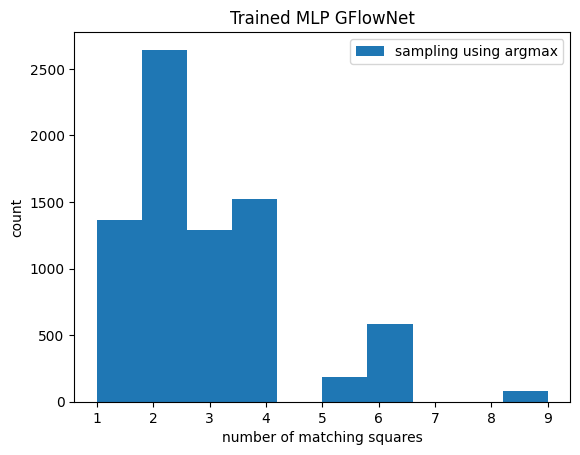

In [16]:
# plt.hist(sampled_matchings[:7680], label='sampling using argmin')
plt.hist(argmax_samplings, label='sampling using argmax')
plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained MLP GFlowNet')
plt.legend()

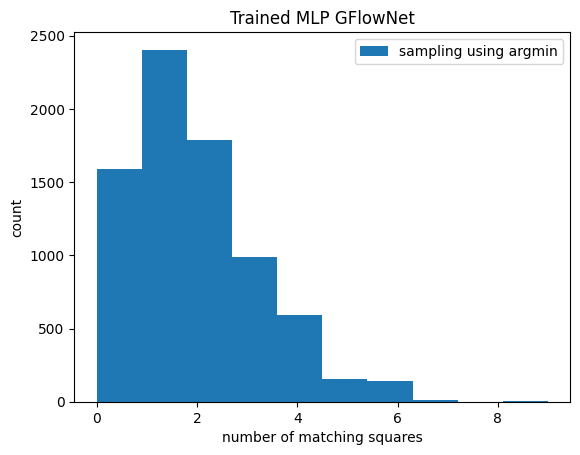

In [17]:
plt.hist(sampled_matchings[:7680], label='sampling using argmin')
#plt.hist(argmax_samplings, label='sampling using argmax')
plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained MLP GFlowNet')
plt.legend()

Text(0.5, 1.0, 'Random GFlowNet, sampling temperature=10')

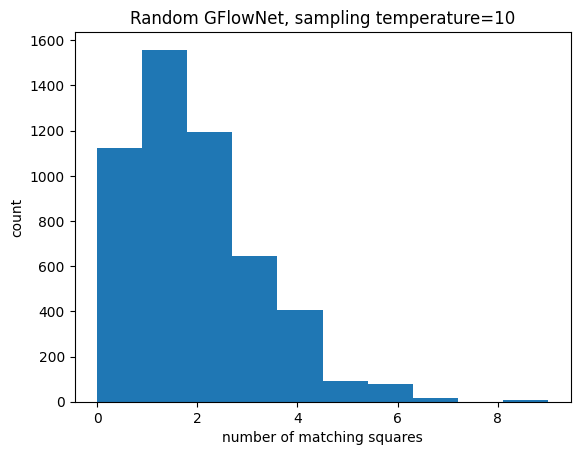

In [30]:
plt.hist(sampled_matchings)

plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Random GFlowNet, sampling temperature=10')

Text(0.5, 1.0, 'Trained GFlowNet (beta=20), sampling temperature=10')

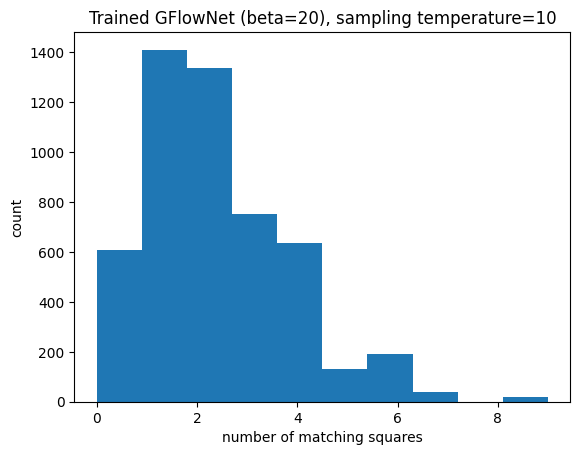

In [28]:
plt.hist(sampled_matchings)

plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained GFlowNet (beta=20), sampling temperature=10')

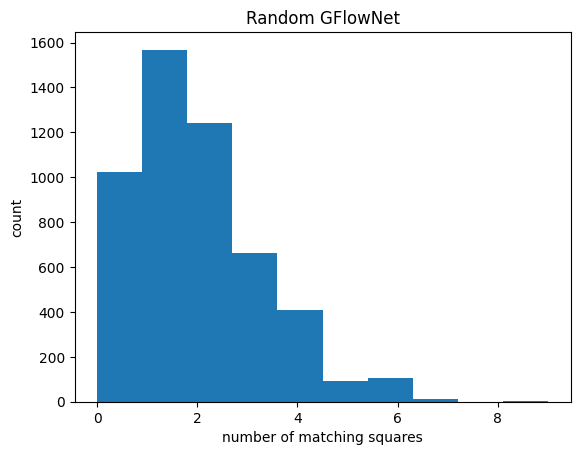

In [14]:
plt.hist(sampled_matchings)

plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained GFlowNet')

In [10]:
a = torch.load('sampled_matchings.pt')

Text(0.5, 1.0, 'Trained GFlowNet')

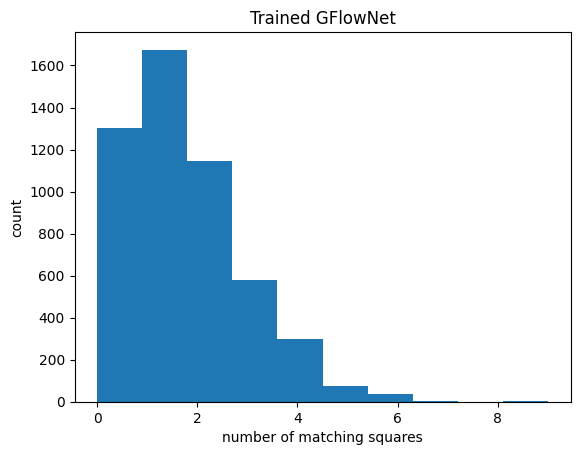

In [13]:
plt.hist(a)
plt.ylabel('count')
plt.xlabel('number of matching squares')
plt.title('Trained GFlowNet')

In [92]:
'''torch.save(sampled_matchings, 'sampled_matchings.pt')
torch.save(sampled_rewards, 'sampled_rewards.pt')'''

"torch.save(sampled_matchings, 'sampled_matchings.pt')\ntorch.save(sampled_rewards, 'sampled_rewards.pt')"

In [43]:
T = torch.Tensor([[0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 5, 1, 1, 1],
        [0, 1, 4, 4, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 4, 2, 1, 2, 4, 5, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 2, 1, 5, 1],
        [0, 4, 1, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 1, 1],
        [0, 4, 3, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 3, 5, 1, 5, 1, 1, 2, 4, 1, 4, 1, 4, 1, 4, 4, 1, 4, 4, 1, 1],
        [0, 4, 1, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 3, 3, 3, 1, 1, 1, 3, 1],
        [0, 3, 1, 4, 4, 4, 1, 4, 4, 3, 3, 4, 4, 3, 4, 4, 4, 3, 4, 4, 1],
        [0, 3, 2, 4, 4, 1, 3, 1, 1, 3, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1],
        [0, 3, 3, 4, 2, 1, 2, 1, 3, 3, 3, 3, 3, 3, 1, 3, 2, 3, 3, 3, 1],
        [0, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 5, 1],
        [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1],
        [0, 1, 1, 1, 1, 1, 4, 1, 4, 1, 5, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1],
        [0, 4, 1, 2, 1, 4, 1, 4, 1, 4, 4, 1, 4, 1, 4, 4, 4, 2, 4, 1, 1],
        [0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 2, 1, 1, 1, 1, 1, 1],
        [0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1]])

In [58]:
torch.where(T[:, 1:] == 1, 1, 0).argmax(dim=1).type(torch.Tensor).mean()

tensor(1.2500)

In [62]:
T = torch.randint(0, 4, (10, 10))
T

tensor([[0, 0, 3, 2, 2, 0, 3, 0, 2, 3],
        [1, 3, 0, 1, 1, 0, 0, 2, 1, 0],
        [1, 1, 2, 0, 2, 0, 1, 3, 2, 1],
        [1, 0, 0, 0, 2, 2, 1, 3, 3, 3],
        [0, 1, 1, 0, 3, 0, 1, 2, 1, 0],
        [0, 3, 3, 1, 1, 0, 1, 0, 0, 3],
        [1, 3, 3, 0, 0, 2, 1, 2, 2, 2],
        [0, 3, 0, 0, 2, 3, 1, 2, 0, 1],
        [3, 0, 3, 3, 0, 1, 3, 0, 1, 1],
        [3, 0, 2, 0, 1, 3, 0, 1, 2, 0]])

In [74]:
for tensor in T:
    print(torch.where(tensor == 1, 1, 0))
    print(torch.where(tensor == 1, 1, 0).argmax())
    print(tensor, '\n\n')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor(0)
tensor([0, 0, 3, 2, 2, 0, 3, 0, 2, 3]) 


tensor([1, 0, 0, 1, 1, 0, 0, 0, 1, 0])
tensor(0)
tensor([1, 3, 0, 1, 1, 0, 0, 2, 1, 0]) 


tensor([1, 1, 0, 0, 0, 0, 1, 0, 0, 1])
tensor(0)
tensor([1, 1, 2, 0, 2, 0, 1, 3, 2, 1]) 


tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0])
tensor(0)
tensor([1, 0, 0, 0, 2, 2, 1, 3, 3, 3]) 


tensor([0, 1, 1, 0, 0, 0, 1, 0, 1, 0])
tensor(1)
tensor([0, 1, 1, 0, 3, 0, 1, 2, 1, 0]) 


tensor([0, 0, 0, 1, 1, 0, 1, 0, 0, 0])
tensor(3)
tensor([0, 3, 3, 1, 1, 0, 1, 0, 0, 3]) 


tensor([1, 0, 0, 0, 0, 0, 1, 0, 0, 0])
tensor(0)
tensor([1, 3, 3, 0, 0, 2, 1, 2, 2, 2]) 


tensor([0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
tensor(6)
tensor([0, 3, 0, 0, 2, 3, 1, 2, 0, 1]) 


tensor([0, 0, 0, 0, 0, 1, 0, 0, 1, 1])
tensor(5)
tensor([3, 0, 3, 3, 0, 1, 3, 0, 1, 1]) 


tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0])
tensor(4)
tensor([3, 0, 2, 0, 1, 3, 0, 1, 2, 0]) 




In [69]:
T

tensor([[0, 0, 3, 2, 2, 0, 3, 0, 2, 3],
        [1, 3, 0, 1, 1, 0, 0, 2, 1, 0],
        [1, 1, 2, 0, 2, 0, 1, 3, 2, 1],
        [1, 0, 0, 0, 2, 2, 1, 3, 3, 3],
        [0, 1, 1, 0, 3, 0, 1, 2, 1, 0],
        [0, 3, 3, 1, 1, 0, 1, 0, 0, 3],
        [1, 3, 3, 0, 0, 2, 1, 2, 2, 2],
        [0, 3, 0, 0, 2, 3, 1, 2, 0, 1],
        [3, 0, 3, 3, 0, 1, 3, 0, 1, 1],
        [3, 0, 2, 0, 1, 3, 0, 1, 2, 0]])